## Task 1

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.\
Mobile Games AB Testing with Cookie Cats

In [153]:
from scipy.stats import ttest_1samp, mannwhitneyu, ttest_ind, shapiro, kstest
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [155]:
df = pd.read_csv(r"cookie_cats.csv", encoding= 'unicode_escape')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [157]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [158]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [159]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [160]:
df.nlargest(5, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1


Убираем выброс

In [161]:
df = df[df.sum_gamerounds < 2962]

In [162]:
df.shape

(90188, 5)

In [163]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018800e+04,90188.000000,90188.000000,90188.000000
mean,4.998397e+06,51.320253,0.445214,0.186056
std,2.883298e+06,102.682719,0.496992,0.389154
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512211e+06,5.000000,0.000000,0.000000
50%,4.995804e+06,16.000000,0.000000,0.000000
75%,7.496461e+06,51.000000,1.000000,0.000000
max,9.999861e+06,2961.000000,1.000000,1.000000


Удержание в течении 1 дня

In [164]:
df.retention_1.value_counts()

0    50035
1    40153
Name: retention_1, dtype: int64

Удержание в течении 7 дней

In [165]:
df.retention_7.value_counts()

0    73408
1    16780
Name: retention_7, dtype: int64

Определим размеры выборок

In [166]:
df.version.groupby(df.version == 'gate_30').count()

version
False    45489
True     44699
Name: version, dtype: int64

In [167]:
df.version.groupby(df.version == 'gate_40').count()

version
False    44699
True     45489
Name: version, dtype: int64

Проверка на нормальность

In [168]:
kstest(df['sum_gamerounds'][df.version == 'gate_30'], 'norm')

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)

In [169]:
kstest(df['sum_gamerounds'][df.version == 'gate_40'], 'norm')

KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)

Распределения не нормальные

In [170]:
mannwhitneyu(df[df.version == 'gate_30'].sum_gamerounds, df[df.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

In [171]:
ttest_ind(df[df.version == 'gate_30'].sum_gamerounds, df[df.version == 'gate_40'].sum_gamerounds)

Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)

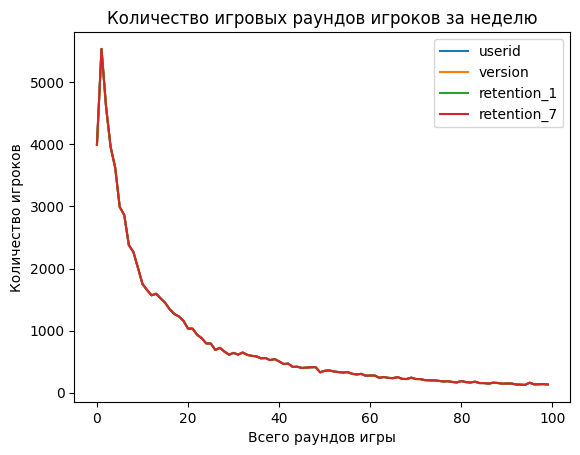

In [172]:
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:100].plot()
ax.set_xlabel('Всего раундов игры')
ax.set_ylabel('Количество игроков')
ax.set_title('Количество игровых раундов игроков за неделю');

Процент удержание в течении 1 дня

In [173]:
100 * df.retention_1.sum()/df.retention_1.count()

44.521444094558035

Процент удержания в течении 1 дня для групп

In [174]:
100 * df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()

version
gate_30    44.819795
gate_40    44.228275
Name: retention_1, dtype: float64

Используем Bootstrapp

In [175]:
b1 = []
for i in range(300):
  bm1 = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  b1.append(bm1)

b1 = pd.DataFrame(b1)

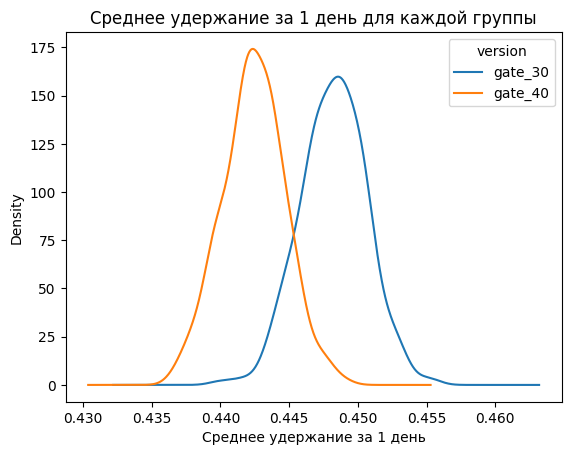

In [176]:
x1 = b1.plot.kde()
x1.set_title('Среднее удержание за 1 день для каждой группы')
x1.set_xlabel('Среднее удержание за 1 день');

Рассчитаем процент удержание в течении 7 дней для двух групп

In [177]:
100 * df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    19.018323
gate_40    18.200004
Name: retention_7, dtype: float64

In [178]:
b7 = []
for i in range(300):
  bm7 = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  b7.append(bm7)

b7 = pd.DataFrame(b7)

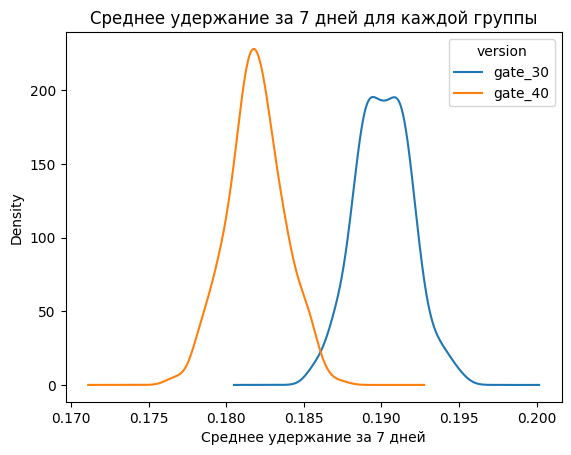

In [179]:
x7 = b7.plot.kde()
x7.set_title('Среднее удержание за 7 дней для каждой группы')
x7.set_xlabel('Среднее удержание за 7 дней');

Удержание в течении 1 и 7 дней выше, когда gate_30. Тесты показали, что для удержания пользователей необходимо оставить первоначальный вариант.